In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

data = load_boston()
data.keys()

/home/simon/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing da

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename', 'data_module'])

In [2]:
data["feature_names"]

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

In [3]:
X, y = data["data"], data["target"]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#here doing the fit_transform sooner instead of later (usually you first do a cross validation)
#reason: read information in cell below
pipe = Pipeline([('std_scl',StandardScaler())])
X_train = pipe.fit_transform(X_train)
X_test = pipe.transform(X_test)
# technically leads to some information leaking into our validation set
# best practice is to write cross validation by hand and perform fit of transformers
# only on reduced test set and then only call transform on validation set

X_train = pd.DataFrame(X_train,columns=data["feature_names"])
X_test = pd.DataFrame(X_test,columns=data["feature_names"])
y_train = pd.DataFrame(y_train,columns=["target"])
y_test = pd.DataFrame(y_test,columns=["target"])

In some specific cases, doing fit_transform before cross-validation might be preferable, despite the potential leakage risk. Here are some scenarios where it might be considered:

1. Simple Scaling with Low Leakage Risk: If the scaling operation is very basic (e.g., normalization) and unlikely to leak information about the target variable, you might prioritize efficiency and perform fit_transform on the entire dataset before splitting. However, be cautious and closely monitor cross-validation metrics for any signs of leakage.

2. Interpretability: In cases where understanding how scaling affects your features is critical for interpretability purposes, observing its impact on the entire training data before splitting can be helpful. However, remember that this doesn't replace the need for proper evaluation using cross-validation to avoid misleading performance estimation.

3. Feature Engineering Efficiency: If your feature engineering pipeline involves multiple complex transformations, performing fit_transform on the entire data might streamline the process by avoiding applying the full pipeline on each fold during cross-validation. However, ensure that the transformations don't leak information and consider alternative approaches if leakage is a concern.

4. Domain Knowledge & Justification: If you have strong domain knowledge that justifies the absence of leakage within your specific scaling approach and dataset, you might choose to prioritize efficiency, especially when dealing with large datasets. This requires careful consideration and thorough validation to ensure the justification holds true.

Remember: Choosing fit_transform before cross-validation comes with potential risks. Only consider it if:

    The leakage risk is minimal or well-understood.
    You have a compelling reason for efficiency or interpretability.
    You can strongly justify the absence of leakage based on domain knowledge.

Always prioritize robust evaluation through proper cross-validation to build trustworthy models that generalize well. If unsure, err on the side of caution and separate fit and transform according to best practices.

---------------

In [5]:
#our plotting function from the pevious lesson
def plotCVResults(cv_res, names):
    fig = plt.figure(figsize=(20,10))
    trainin_time_ax = fig.add_subplot(2,1,2)
    for i in range(4):
        name = names[i]
        df_reg = pd.DataFrame(cv_res[i])

        ax = fig.add_subplot(2,4,i+1)

        ax.set_title(name + " scores, adj. avg test: " + \
                     str(round(df_reg.loc[df_reg["test_score"]>0]["test_score"].mean(),2)))
        ax.set_xlabel("iteration")
        ax.set_ylabel("R2 score")
        ax.set_ylim(0,1)
        df_reg[["train_score","test_score"]].plot(ax=ax)

        df_reg["fit_time"].plot(ax=trainin_time_ax,label=name)

    plt.sca(trainin_time_ax)
    plt.legend()
    plt.show()

In [6]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_validate

cv_res = []
for n_neighbors in range(1,17,5): #large range of neighbors going from 1 to 16
    #same parameters as in the knn classifier
    cv_res.append(cross_validate(KNeighborsRegressor(n_neighbors=n_neighbors,
                                               weights='uniform'), 
                            X_train,
                            y_train,
                            cv = 5,# we will keep it at 5, since that gives each sample set around 80 samples
                            return_train_score = True,
                            return_estimator = True,
                            n_jobs = 2))

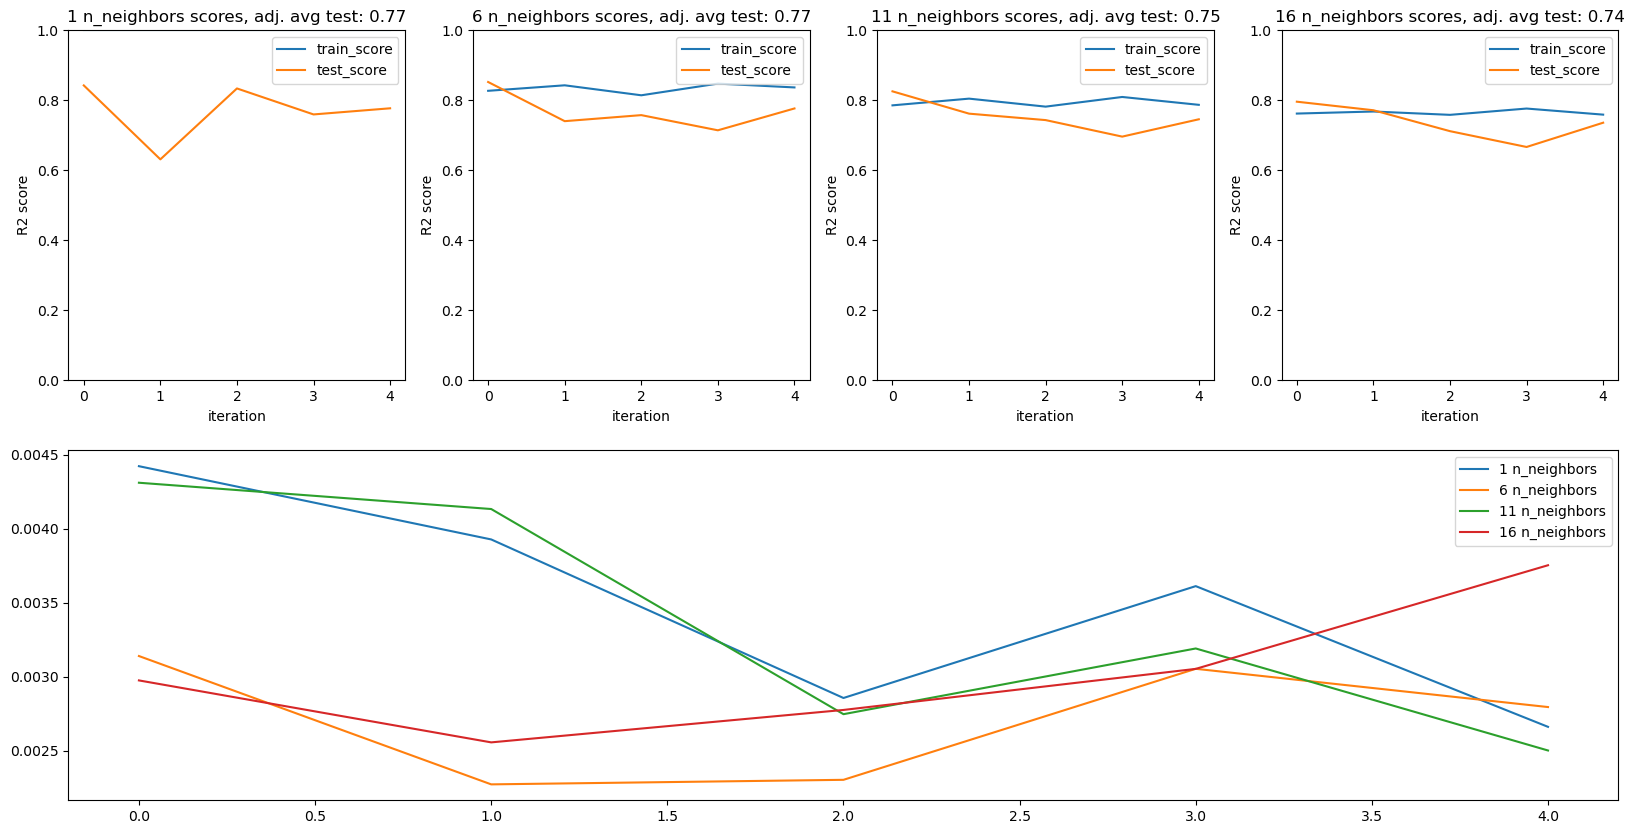

In [8]:
plotCVResults(cv_res, [str(x)+' n_neighbors' for x in range(1,17,5)])

#result: very low training times, scores all look the same, 
#average scores with some slight underfitting from 11 to 16, 
#important: USE THE STANDARD SCALER HERE (without it we'll see a large performance drop),
#numerical values deal better with features that are scaled
#do the fit_transform later on the reduced training set (after cross-validation) 
#=> only apply transform on the validation set